In [123]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import glob

# Root directory of the project,
# needed for external modules etc
ROOT_DIR = os.path.abspath("../../") 

TEMP_DIR = "/home/blaise/code/grisehale_nmbu/src/01_video_analyzer/02_temp" 
#ANNOTATION_FILE = "batch1_coco_2019-09-30_1132.json"
#annotations_file_path = os.path.join(DATA_DIR,ANNOTATION_FILE)
#PIGS_ONLY_FOLDER = "/data/open_datasets/open_images_v5/images/pigsonly" #pigs from open image v5

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

sys.path.append("/home/blaise/code/grisehale_nmbu/src/lbbx2coco")
import olatools
import json
from PIL import Image, ImageDraw

#import centroidtracker
CENTREIODTRACKER_DIR = "/home/blaise/code/matterport_demo/simple-object-tracking/pyimagesearch"
sys.path.append(CENTREIODTRACKER_DIR)
import centroidtracker


%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    print("tried to download")
    #utils.download_trained_weights(COCO_MODEL_PATH)

In [2]:
class ShapesConfig(Config):
    """
    Edit: adopting example to train on pig images
    
    Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "pigs"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    # seems to ba an issue with more than 1 gpu see issue no 921 in repo
    # fix : https://github.com/yoninachmany/spacenet-rio-buildings-mask-rcnn/commit/5a2a68e830b6878a9a06175ac9be4c3bfa22f1bc
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    # start with pigs only
    NUM_CLASSES = 1 + 3  # background + 3 pig_classes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 1280

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels // added 256, 512 -> got: IndexError: index 5 is out of bounds for axis 0 with size 5

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 128 #org sugg val 32

    # Use a small epoch since the data is simple
    #STEPS_PER_EPOCH = 100
    #"If you have a training set of fixed size you can ignore it.." [1]

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    #similar to steps_per_epoch but on the validation data set instead on the training data. If you have the time to go through your whole validation data set I recommend to skip this parameter. [1]
    
    #ref [1] https://datascience.stackexchange.com/questions/29719/how-to-set-batch-size-steps-per-epoch-and-validation-steps

config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1280
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1280 1280    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [4]:
class PigsDataset(utils.Dataset):

    def load_pigs(self, count, height, width):
        """
        load pig files into dataset object from mrcnn
        """
        
        # Add classes
        self.add_class("pigs", 1, "pig_body")
        self.add_class("pigs", 2, "pig_head")
        self.add_class("pigs", 3, "pig_tail")

        # Add images to image list (see parent class)
        # Todo : add images with/from annotation file instead of file directory
        os.chdir(TEMP_DIR+"/frames/")
        
        counter = 0
        for file in glob.glob("*.jpg"):
            if counter>=count:
                break
            else: counter = counter + 1
            tmp_id = int(olatools.intify_filename(file))
            #print("image_id: ", tmp_id, "\npath: ",file)
            test = self.add_image("pigs", image_id=tmp_id, path=file) #width=width, height=height, bg_color=bg_color, shapes="pig")            
            #test = self.add_image("pigs", image_id=1234, path="/file")
            #print(test)
        
        






In [5]:
# Training dataset
#dataset_train = PigsDataset()
#dataset_train.load_pigs(500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
#dataset_train.prepare()

# Validation dataset
dataset_vid = PigsDataset()
dataset_vid.load_pigs(5, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_vid.prepare()

In [7]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/blaise/code/matterport_demo/MRCNN-custom/logs/pigs20191003T0726/mask_rcnn_pigs_0002.h5
Re-starting from epoch 2


Processing 1 images
image                    shape: (2736, 3648, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1280, 1280, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 3648.00000  float64
anchors                  shape: (1, 409200, 4)        min:   -0.07077  max:    1.02073  float32
[ 522 2165 1263 2775]
[1157 2421 1958 2758]
[ 634 1811 1542 2290]
[ 530 1331 1247 2026]
[1212 2795 1755 3157]
Processing 1 images
image                    shape: (2736, 3648, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1280, 1280, 3)    min: -123.70000  max:  142.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 3648.00000  float64
anchors                  shape: (1, 409200, 4)        min:   -0.07077  max:    1.02073  float32
[1175 2061 1529 2966]
[1622 2081 2238 2910]
[ 295 1839 1052 2573]
[ 344 1313  943 2241

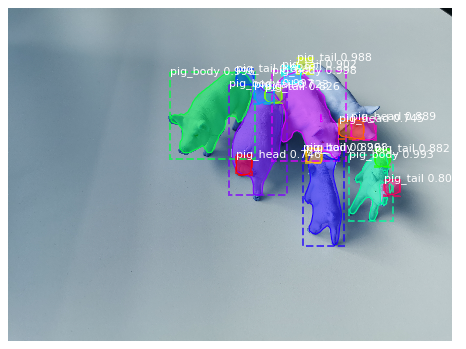

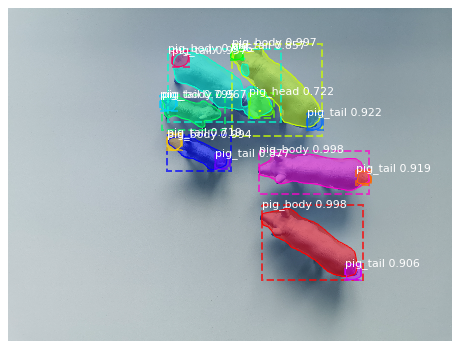

In [140]:
#input images
os.chdir(TEMP_DIR+"/frames/") #should be frames 
images = [img for img in os.listdir(TEMP_DIR+"/delete") if img.endswith(".jpg")]
height, width, layers = cv2.imread(images[0]).shape

#video = cv2.VideoWriter(video_name, 0, 25, (width,height))
images.sort()

#pig pen estimates and scale factors
w_m = 4
h_m = 3
w_px2m_fac = w_m/width
h_px2m_fac = h_m/height

#constants for dashboard
y_offset = 40
x_offset = 10
line_space = 40
h, w, _ = cv2.imread(images[0]).shape

#initialize tracking structures
obj_track = centroidtracker.CentroidTracker()
trvl_hst = [[] for i in range(16)] #todo: move to cetroid tracker and make size dynamic
ttl_dstc = np.zeros(14)
speeds = np.zeros(14)

img_counter = 1000
for image in images:
    img_counter +=  1
    #if img_counter>1050:
    #    break
    frame = cv2.imread(image)
    results = model.detect([frame], verbose=1)
    
    #filter out pigs_bb from results
    pig_bdy_bbs = []
    counter = 0
    for obj_id in results[0]["class_ids"]:
        if obj_id == 1:
            #object is pig
            print(results[0]["rois"][counter])
            pig_bdy_bbs.append(results[0]["rois"][counter])
        counter += 1

    #feed object tracer with pig_BBs
    objects = obj_track.update(pig_bdy_bbs)
    
    #Log travel history // #todo: move this into object tracker
    for obj_id in range(len(trvl_hst)):
        if obj_id in objects.keys(): 
            trvl_hst[obj_id].append(objects[obj_id])
        else: 
            trvl_hst[obj_id].append([0, 0])
            
    #Caluculate total distance and velocity #todo: move this into object tracker
    #only check each x-th frame this is easyfix before landtek fix more better later
    #make moving average in stead of skipping/ remove skipper later. set to 1 for now
    jump_frames = 1
    window = 25
    if img_counter>(1001+window): #skip first frames /two sec
        if img_counter%jump_frames==0: #skip frames to avoid noise accumulation  (ugly fix)
            for pig_ID in range(len(trvl_hst)):
                pig_path = trvl_hst[pig_ID]
                last_index=len(pig_path)-1
                prev_index=last_index-jump_frames
                #y1, x1 = pig_path[prev_index]#[last_index-1]
                #y2, x2 = pig_path[last_index]
                y1, x1 = pig_path[prev_index-window:prev_index]
                distance = math.sqrt(((x2 - x1)*w_px2m_fac)**2 + ((y2 - y1)*h_px2m_fac)**2) 
                ttl_dstc[pig_ID] += distance
                #print("\n\ndistance: {} \n\ntotal distance: {}".format(distance,ttl_dstc[pig_ID]))
                #print("\n\ny1:{} x1:{} y2:{} x2:{}".format(y1,x2,y2,x2))
    
    #put ID info on image
    alpha = 0.5
    overlay = frame.copy()
    output = frame.copy()
    for (objectID, centroid) in objects.items():
        #print("objectID: {}, centroid: {}".format(objectID,centroid))
        # draw both the ID of the object and the centroid of the
        # object on the output frame

        #text = "G:{} Dist{}".format(objectID,int(ttl_dstc[objectID])
        text = "G:{}".format(objectID)
        cv2.circle(overlay, (centroid[1], centroid[0]), 40, (255, 255, 255,), -1)
        cv2.putText(overlay, text, (centroid[1]-35, centroid[0]+7),
            cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)
        
    #fuse overlay with background
    cv2.addWeighted(overlay, alpha, output, 1 - alpha,0, output)
    
    #Make dashboard view
    blackground = np.zeros((height, int(1.3*width), layers),dtype=np.uint8)
    blackground[0:h, 0:w, 0:4] += output 
    heading = "G:ID  dist[m]  vel[m/s]"
    cv2.putText(blackground, heading, (w+x_offset, 0+y_offset), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    for i in range(len(ttl_dstc)):
        id = i
        dist = round(ttl_dstc[i],1)
        vel = ""
        text = "G:{}      {}         {}".format(i,dist,vel)
        cv2.putText(blackground, text, (w+x_offset, 0+y_offset+((i+1)*line_space)), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    
    
    r = results[0]
    img = visualize.display_instances(frame, r['rois'], r['masks'], r['class_ids'], dataset_vid.class_names, r['scores'], ax=get_ax())
    plt.imsave('/home/blaise/code/grisehale_nmbu/src/01_video_analyzer/02_temp/dashboard/test%d.jpg' % img_counter, blackground.astype(np.uint8))
    


In [163]:
x = [[1,2],[3,4],[5,6],[7,8]]
y = x[1:3]


In [164]:
c = np.array(y).dot(np.array([[1],[1]]))

In [168]:
c.shape

(2, 1)

In [120]:
test=cv2.imread(images[0])
print(images[0])
print(type(test))
#plt.imshow(test)

IMG_20191022_135957.jpg
<class 'NoneType'>


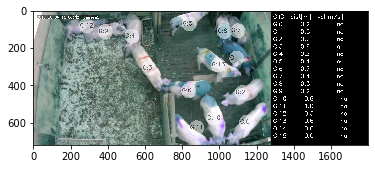

In [101]:



blackground = np.zeros((720,1800,3),dtype=np.uint8)
blackground[0:h, 0:w, 0:4] += output 
heading = "G:ID  dist[m]  vel[m/s]"
cv2.putText(blackground, heading, (w+x_offset, 0+y_offset), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
for i in range(len(ttl_dstc)):
    id = i
    dist = round(ttl_dstc[i],1)
    vel = ""
    text = "G:{}      {}         {}".format(i,dist,vel)
    cv2.putText(blackground, text, (w+x_offset, 0+y_offset+((i+1)*line_space)), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    
#plt.imshow(blackground)
plt.imsave('/home/blaise/code/grisehale_nmbu/src/01_video_analyzer/02_temp/dashboard/test000.jpg', blackground.astype(np.uint8))

In [ ]:

#put ID info on image
alpha = 0.5
overlay = frame.copy()
output = frame.copy()
for (objectID, centroid) in objects.items():
    #print("objectID: {}, centroid: {}".format(objectID,centroid))
    # draw both the ID of the object and the centroid of the
    # object on the output frame

    text = "G:{}".format(objectID)
    cv2.circle(overlay, (centroid[1], centroid[0]), 40, (255, 255, 255,), -1)
    cv2.putText(overlay, text, (centroid[1]-35, centroid[0]+7),
        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)

cv2.addWeighted(overlay, alpha, output, 1 - alpha,0, output)
plt.imshow(output)

In [ ]:
plt.imsave('/home/blaise/code/grisehale_nmbu/src/01_video_analyzer/02_temp/test.png', img.astype(np.uint8))

2

In [ ]:
fig2 = plt.figure(figsize = (15,15)) # create a 5 x 5 figure 
ax3 = fig2.add_subplot(111)
ax3.imshow(frame, interpolation='none')
ax3.set_title('larger figure')

plt.show()

In [ ]:
image = cv2.imread('frame1000.jpg')
overlay = image.copy()

x, y, w, h = 100, 100, 100, 100  # Rectangle parameters
cv2.rectangle(overlay, (x, y), (x+w, y+h), (0, 200, 0), -1)  # A filled rectangle

alpha = 0.4  # Transparency factor.

# Following line overlays transparent rectangle over the image
image_new = cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0)


fig2 = plt.figure(figsize = (15,15)) # create a 5 x 5 figure 
ax3 = fig2.add_subplot(111)
ax3.imshow(output, interpolation='none')
ax3.set_title('larger figure')

plt.show()


In [ ]:
ls